In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset paths
train_path = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\TRAIN'
test_path = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\TEST'

# New dataset path in working directory (for organizing the new structure)
new_dataset_path = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\new_pd_detection'
train_dest_path = os.path.join(new_dataset_path, 'Train')
test_dest_path = os.path.join(new_dataset_path, 'Test')

# Create new directory structure for organized dataset
os.makedirs(train_dest_path, exist_ok=True)
os.makedirs(test_dest_path, exist_ok=True)
os.makedirs(os.path.join(train_dest_path, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(train_dest_path, 'Pd'), exist_ok=True)
os.makedirs(os.path.join(test_dest_path, 'Healthy'), exist_ok=True)
os.makedirs(os.path.join(test_dest_path, 'Pd'), exist_ok=True)

# Function to extract speaker ID from filename (optional)
def get_speaker_id(filename):
    return filename.split('_')[0]  # Assuming speaker ID is the first part of filename

# Copying training data into new structure
for category in ['Healthy', 'Pd']:
    category_files = os.listdir(os.path.join(train_path, category))
    for filename in category_files:
        shutil.copy(os.path.join(train_path, category, filename),
                    os.path.join(train_dest_path, category, filename))
    print(f"Copied {len(category_files)} files to Train/{category}.")

# Process test data, ensuring no data leakage
for category in ['Healthy', 'Pd']:
    test_files = os.listdir(os.path.join(test_path, category))
    
    # Get speaker IDs based on filenames (optional, if splitting by speaker)
    speakers = set()
    for filename in test_files:
        speaker_id = get_speaker_id(filename)
        speakers.add(speaker_id)

    # Split speakers into train and test (if needed)
    train_speakers, test_speakers = train_test_split(list(speakers), test_size=0.25, random_state=42)

    # Copy test files into the appropriate new structure
    for filename in test_files:
        speaker_id = get_speaker_id(filename)
        if speaker_id in train_speakers:
            shutil.copy(os.path.join(test_path, category, filename),
                        os.path.join(train_dest_path, category, filename))
        else:
            shutil.copy(os.path.join(test_path, category, filename),
                        os.path.join(test_dest_path, category, filename))

    print(f"Processed and copied {len(test_files)} files for category '{category}' into Train and Test sets.")

print("Dataset copying and split completed.")


Copied 4409 files to Train/Healthy.
Copied 4229 files to Train/Pd.
Processed and copied 1106 files for category 'Healthy' into Train and Test sets.
Processed and copied 817 files for category 'Pd' into Train and Test sets.
Dataset copying and split completed.


In [4]:
import os
from PIL import Image

# Function to clean the directory by removing non-image or corrupted files
def clean_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # Open the file to verify it's a valid image
                img = Image.open(file_path)
                img.verify()  # Check if the file is an image
            except (IOError, SyntaxError):
                # If not an image, remove the file
                print(f"Removing corrupted or non-image file: {file_path}")
                os.remove(file_path)

# Clean the Train and Test directories to remove non-image files
train_dest_path = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\new_pd_detection\Train'  # Your Train directory path
test_dest_path = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\new_pd_detection\Test'    # Your Test directory path

# Apply the cleaning function to both Train and Test datasets
clean_directory(train_dest_path)
clean_directory(test_dest_path)

print("Dataset cleaning completed.")


Dataset cleaning completed.


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = r'C:\Users\sowmya\Downloads\Sowmya_new_ds\new_pd_detection'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
val_dir = os.path.join(base_dir, 'Validation')

# Create validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    os.makedirs(os.path.join(val_dir, 'healthy'))
    os.makedirs(os.path.join(val_dir, 'pd'))

# Split the training data into training and validation sets (80/20)
for category in ['healthy', 'pd']:
    # Get list of files in each category
    category_files = os.listdir(os.path.join(train_dir, category))
    
    # Split the data into 80% training and 20% validation
    train_files, val_files = train_test_split(category_files, test_size=0.2, random_state=42)

    # Move the files to the respective directories
    for filename in val_files:
        shutil.move(os.path.join(train_dir, category, filename),
                    os.path.join(val_dir, category, filename))

    print(f"Moved {len(val_files)} files to Validation set for category '{category}'")

# Define ImageDataGenerators for data augmentation (train) and rescaling (test/validation)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Rotation augmentation range
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zoom augmentation
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Filling in missing pixels after transformation
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescale for validation and test data

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True  # Shuffle training data
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # No shuffle for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # No shuffle for test data
)

print("Image data generators created successfully.")


Moved 844 files to Validation set for category 'healthy'
Moved 785 files to Validation set for category 'pd'
Found 6510 images belonging to 2 classes.
Found 8858 images belonging to 2 classes.
Found 1923 images belonging to 2 classes.
Image data generators created successfully.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer

# Define the custom CNN model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


c:\Users\sowmya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\sowmya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.5816 - loss: 0.6807 - val_accuracy: 0.6053 - val_loss: 0.6283
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.8201 - loss: 0.4110 - val_accuracy: 0.8872 - val_loss: 0.3198
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9108 - loss: 0.2248 - val_accuracy: 0.7837 - val_loss: 0.4249
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.9429 - loss: 0.1603 - val_accuracy: 0.9392 - val_loss: 0.1666
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9478 - loss: 0.1439 - val_accuracy: 0.9761 - val_loss: 0.0993
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9563 - loss: 0.1200 - val_accuracy: 0.9698 - val_loss: 0.1021
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9575 - loss: 0.1175 - val_accuracy: 0.9522 - val_loss: 0.1446
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9637 - loss: 0.1013 - val_accu

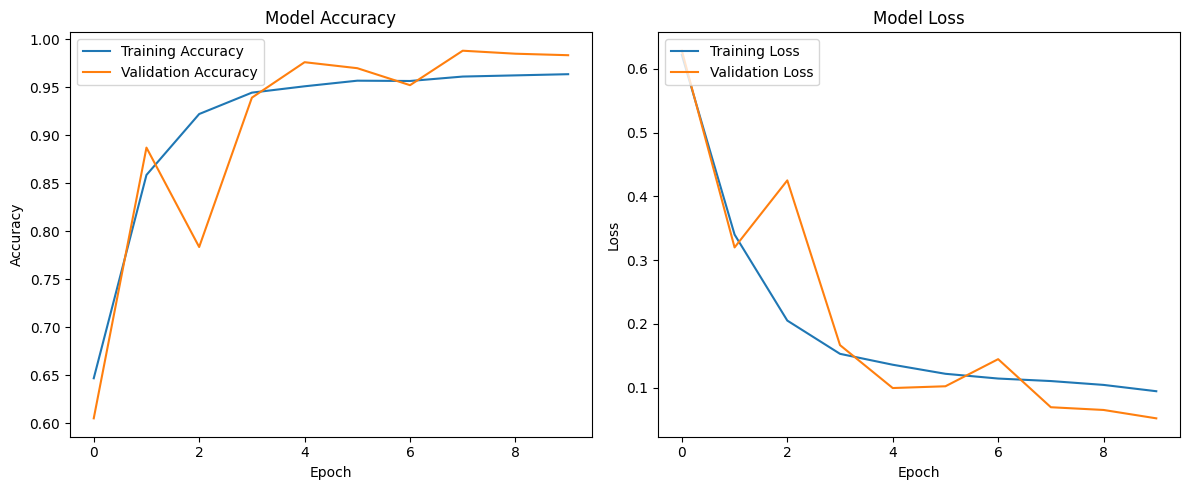

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - accuracy: 0.9772 - loss: 0.0596
Test accuracy: 0.9833593368530273
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 480ms/step


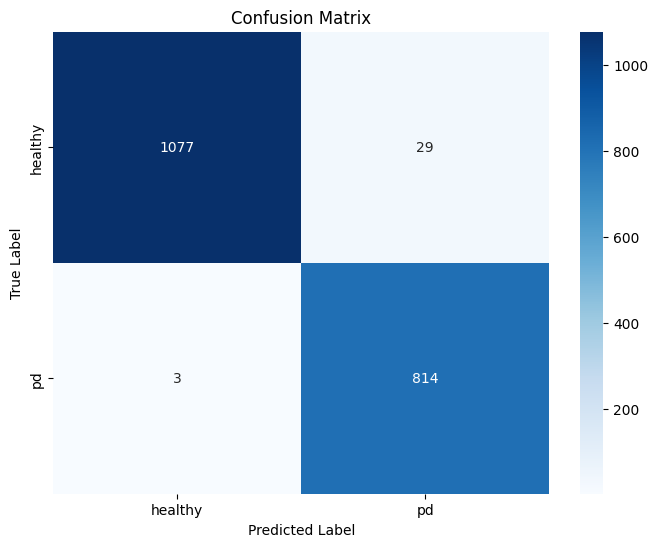

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      0.97      0.99      1106
          pd       0.97      1.00      0.98       817

    accuracy                           0.98      1923
   macro avg       0.98      0.99      0.98      1923
weighted avg       0.98      0.98      0.98      1923



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

# Get the true labels and predicted labels for the test set
test_generator.reset()  # Ensure the generator is at the start
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten()  # Binary threshold at 0.5
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class labels

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
